# Shill Bidding Dataset Analysis

In [1]:
import pandas as pd
import numpy as np
from numpy import where
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from scipy import stats
#from scipy.special import boxcox1p
#from scipy.stats import boxcox_normmax
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier
from sklearn.svm import SVC

#Common Model Helpers
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import pyplot


from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import optuna

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline

seed = 42

In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


In [3]:
shill = pd.read_csv('Shill_Bidding_Dataset.csv')
shill.head()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


In [4]:
X = shill.drop(columns=['Class', 'Record_ID', 'Auction_ID', 'Bidder_ID'])
y = shill.Class
X

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration
0,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5
1,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5
2,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5
3,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5
4,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7
...,...,...,...,...,...,...,...,...,...
6316,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3
6317,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7
6318,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7
6319,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7


In [5]:
y.value_counts()

0    5646
1     675
Name: Class, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = seed)

print(f"Training set: {X_train.shape[0]}")
print(f"Validation set: {X_val.shape[0]}")
print(f"Test set: {X_test.shape[0]}")

Training set: 4044
Validation set: 1012
Test set: 1265


# Class balance by Undersampling

When undersampling, we aim to remove a number of the rows of the majority class (rows where class=0) in order to match the number of rows of the minority class (rows where class=1).

In [7]:
y_train.value_counts()

0    3612
1     432
Name: Class, dtype: int64

In [8]:
rus = RandomUnderSampler(random_state=seed)
X_train_us_ini, y_train_us_ini = rus.fit_resample(X_train, y_train)

In [9]:
y_train_us_ini.value_counts()

0    432
1    432
Name: Class, dtype: int64

In [10]:
X_train_us, X_val_us, y_train_us, y_val_us = train_test_split(X_train_us_ini, y_train_us_ini, test_size=0.2, random_state = seed)

# Class balance by oversampling with SMOTE

Now, oversampling will be performed on the training data.

In [11]:
y_train.value_counts()

0    3612
1     432
Name: Class, dtype: int64

In [12]:
smote = SMOTE(random_state=seed)

X_train_os_ini, y_train_os_ini = smote.fit_resample(X_train, y_train)

y_train_os_ini.value_counts()

0    3612
1    3612
Name: Class, dtype: int64

In [13]:
X_train_os, X_val_os, y_train_os, y_val_os = train_test_split(X_train_os_ini, y_train_os_ini, stratify=y_train_os_ini, test_size=0.2, random_state = seed)

# Hybrid Sampling Method

A combination of under- and oversampling method using pipeline

In [14]:
# define pipeline
over = SMOTE(sampling_strategy = "not minority")
under = RandomUnderSampler(sampling_strategy = "majority")
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_h, y_h = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_h)
print(counter)

Counter({0: 675, 1: 675})


In [15]:
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.2, stratify = y_h, random_state=seed)

scaler = StandardScaler()

X_train_h = scaler.fit_transform(X_train_h)
X_test_h = scaler.transform(X_test_h)

X_train_h, X_val_h, y_train_h, y_val_h = train_test_split(X_train_h, y_train_h, test_size=0.2, stratify=y_train_h, random_state=seed)

print(f"Training set: {X_train_h.shape[0]}")
print(f"Validation set: {X_val_h.shape[0]}")
print(f"Test set: {X_test_h.shape[0]}")

Training set: 864
Validation set: 216
Test set: 270


# Applying Ensemble Learning Algorithms

Ensemble Algorithms

    1. Bagged Decision Trees
    2. Extra Trees
    3. Stochastic Gradient Boosting
    4. AdaBoost
    5. XGBoost
    6. Gradient Boosting
    
Hyperparameter Tuning
After spot-checking machine learning algorithms and imbalanced algorithms, you will have some idea of what works and what does not on your specific dataset.

The simplest approach to hyperparameter tuning is to select the top five or 10 algorithms or algorithm combinations that performed well and tune the hyperparameters for each.

There are three popular hyperparameter tuning algorithms that you may choose from:

    Random Search
    Grid Search
    Bayesian Optimization

## Bagged Decision Trees

### Imbalanced data

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#### Applying Algorithm

In [17]:
# kfold = KFold(n_splits = 10, random_state = seed)
# cart = DecisionTreeClassifier()
# scaler = StandardScaler()

# X_scaled = scaler.fit_transform(X)

# kfold = model_selection.KFold(n_splits=10, random_state=42)
# bclf = BaggingClassifier(base_estimator = cart, n_estimators = 200, random_state = seed)

# scoring = ['accuracy', 'precision', 'recall', 'f1']

# results = model_selection.cross_validate(bclf, X_scaled, y, cv = kfold, scoring = scoring)

# for name in results.keys():
#      print('{} {:.6f}'.format(name, np.average(results[name])))

In [18]:
cart = DecisionTreeClassifier()
scaler = StandardScaler()


bclf = BaggingClassifier(base_estimator = cart, random_state = seed)

In [19]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

bclf.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [20]:
param_grid = {'max_samples': [0.05, 0.1, 0.2, 0.5],
              'max_features': [0.3,0.5,0.7,0.9],
             }


sh = HalvingGridSearchCV(bclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=30).fit(X_train, y_train)
sh.best_estimator_
# bclf = BaggingClassifier(base_estimator = cart, n_estimators = 402, max_samples = 0.08, max_features = 0.06, random_state = seed).fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.9,
                  max_samples=0.5, n_estimators=16, random_state=42)

In [21]:
bclf = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 16, max_samples = 0.5, max_features = 0.9, random_state = seed).fit(X_train, y_train)
y_pred = bclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.998230  0.998230  0.998230      1130
         Yes   0.985185  0.985185  0.985185       135

    accuracy                       0.996838      1265
   macro avg   0.991708  0.991708  0.991708      1265
weighted avg   0.996838  0.996838  0.996838      1265



### Undersampled Data

In [22]:
bclf = BaggingClassifier(base_estimator = cart, random_state = seed)

In [23]:
# hyperparameter tuning
param_grid = {'max_samples': [0.05, 0.1, 0.2, 0.5],
              'max_features': [0.3,0.5,0.7,0.9],
             }


sh = HalvingGridSearchCV(bclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=30).fit(X_train_us, y_train_us)
sh.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.9,
                  max_samples=0.5, n_estimators=16, random_state=42)

In [24]:
bclf = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 16, max_samples = 0.5, max_features = 0.9, random_state = seed).fit(X_train_us, y_train_us)
y_pred = bclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.981416  0.990621      1130
         Yes   0.865385  1.000000  0.927835       135

    accuracy                       0.983399      1265
   macro avg   0.932692  0.990708  0.959228      1265
weighted avg   0.985634  0.983399  0.983920      1265



### Oversampled Data

In [25]:
bclf = BaggingClassifier(base_estimator = cart, random_state = seed)

In [26]:
# hyperparameter tuning
param_grid = {'max_samples': [0.05, 0.1, 0.2, 0.5],
              'max_features': [0.3,0.5,0.7,0.9],
             }


sh = HalvingGridSearchCV(bclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=30).fit(X_train_os, y_train_os)
sh.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.9,
                  max_samples=0.5, n_estimators=16, random_state=42)

In [27]:
bclf = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 16, max_samples = 0.5, max_features = 0.9, random_state = seed).fit(X_train_os, y_train_os)
y_pred = bclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.999114  0.998230  0.998672      1130
         Yes   0.985294  0.992593  0.988930       135

    accuracy                       0.997628      1265
   macro avg   0.992204  0.995411  0.993801      1265
weighted avg   0.997639  0.997628  0.997632      1265



### Hybrid Sampled Data

In [28]:
bclf = BaggingClassifier(base_estimator = cart, n_estimators = 150, random_state = seed)

In [29]:
# hyperparameter tuning
param_grid = {'max_samples': [0.05, 0.1, 0.2, 0.5],
              'max_features': [0.3,0.5,0.7,0.9],
             }


sh = HalvingGridSearchCV(bclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=30).fit(X_train_h, y_train_h)
sh.best_params_

{'max_features': 0.9, 'max_samples': 0.2, 'n_estimators': 16}

In [30]:
bclf = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 16, max_samples = 0.5, max_features = 0.9, random_state = seed).fit(X_train_h, y_train_h)

y_pred = bclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.330088  0.496341      1130
         Yes   0.151345  1.000000  0.262902       135

    accuracy                       0.401581      1265
   macro avg   0.575673  0.665044  0.379621      1265
weighted avg   0.909432  0.401581  0.471428      1265



## Extra Trees Classifiers

### Imbalanced Data

In [81]:
from sklearn.ensemble import ExtraTreesClassifier
xtclf = ExtraTreesClassifier(n_estimators = 150, max_features = 5)
xtclf.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [84]:
# hyperparameter tuning
param_grid = {#'max_depth': [0.05, 0.1, 0.2, 0.5],
              'max_features': [0.3,0.5,0.7,0.9],
              #'n_jobs': [20, 60, 80, 120]
             }


sh = HalvingGridSearchCV(xtclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=30).fit(X_train, y_train)
sh.best_estimator_

ExtraTreesClassifier(max_features=0.9, n_estimators=28)

In [86]:
xtclf = ExtraTreesClassifier(n_estimators = 28, max_features = 0.9).fit(X_train, y_train)

y_pred = xtclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.997352  1.000000  0.998674      1130
         Yes   1.000000  0.977778  0.988764       135

    accuracy                       0.997628      1265
   macro avg   0.998676  0.988889  0.993719      1265
weighted avg   0.997635  0.997628  0.997617      1265



### Undersampled Data

In [91]:
xtclf = ExtraTreesClassifier(n_estimators = 150, max_features = 5)


In [99]:
# hyperparameter tuning
param_grid = {#'max_depth': [0.05, 0.1, 0.2, 0.5],
              'max_features': [0.3,0.5,0.7,0.9],
              #'n_jobs': [20, 60, 80, 120]
             }


sh = HalvingGridSearchCV(xtclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=30).fit(X_train_us, y_train_us)
sh.best_estimator_

ExtraTreesClassifier(max_features=0.7, n_estimators=28)

In [100]:
xtclf = ExtraTreesClassifier(n_estimators = 28, max_features = 0.7).fit(X_train_us, y_train_us)

y_pred = xtclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.983186  0.991522      1130
         Yes   0.876623  1.000000  0.934256       135

    accuracy                       0.984980      1265
   macro avg   0.938312  0.991593  0.962889      1265
weighted avg   0.986833  0.984980  0.985410      1265



### Oversampled Data

In [101]:
xtclf = ExtraTreesClassifier(n_estimators = 150, max_features = 5)


In [104]:
# hyperparameter tuning
param_grid = {#'max_depth': [0.05, 0.1, 0.2, 0.5],
              'max_features': [0.3,0.5,0.7,0.9],
              #'n_jobs': [20, 60, 80, 120]
             }


sh = HalvingGridSearchCV(xtclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=30).fit(X_train_os, y_train_os)
sh.best_estimator_

ExtraTreesClassifier(max_features=0.9, n_estimators=28)

In [105]:
xtclf = ExtraTreesClassifier(n_estimators = 28, max_features = 0.9).fit(X_train_os, y_train_os)

y_pred = xtclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.996473  1.000000  0.998233      1130
         Yes   1.000000  0.970370  0.984962       135

    accuracy                       0.996838      1265
   macro avg   0.998236  0.985185  0.991598      1265
weighted avg   0.996849  0.996838  0.996817      1265



### Hybrid Sampled Data

In [38]:
xtclf = ExtraTreesClassifier(n_estimators = 150, max_features = 5).fit(X_train_h, y_train_h)
y_pred = xtclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.810619  0.895406      1130
         Yes   0.386819  1.000000  0.557851       135

    accuracy                       0.830830      1265
   macro avg   0.693410  0.905310  0.726628      1265
weighted avg   0.934562  0.830830  0.859382      1265



## Stochastic Gradient Boosting

### Imbalanced Dataset

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
# kfold = KFold(n_splits = 10, random_state = seed)
# scaler = StandardScaler()

# X_scaled = scaler.fit_transform(X)

# kfold = model_selection.KFold(n_splits=10, random_state=42)

# gbclf = GradientBoostingClassifier(n_estimators = 50, random_state=seed)

# scoring = ['accuracy', 'precision', 'recall', 'f1']

# results = model_selection.cross_validate(gbclf, X_scaled, y, cv = kfold, scoring = scoring)

# for name in results.keys():
#      print('{} {:.6f}'.format(name, np.average(results[name])))

In [40]:
gbclf = GradientBoostingClassifier(n_estimators = 50, random_state=seed).fit(X_train, y_train)

y_pred = gbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.998229  0.997345  0.997787      1130
         Yes   0.977941  0.985185  0.981550       135

    accuracy                       0.996047      1265
   macro avg   0.988085  0.991265  0.989668      1265
weighted avg   0.996063  0.996047  0.996054      1265



Feature: 0, Score: 0.00314
Feature: 1, Score: 0.00965
Feature: 2, Score: 0.85907
Feature: 3, Score: 0.00068
Feature: 4, Score: 0.00013
Feature: 5, Score: 0.00019
Feature: 6, Score: 0.00038
Feature: 7, Score: 0.05390
Feature: 8, Score: 0.07285


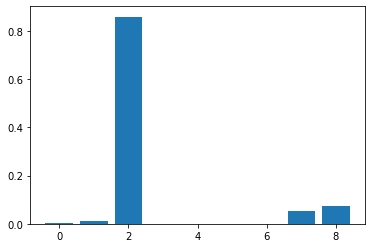

In [41]:
importance = gbclf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Undersampled Dataset

In [42]:
gbclf = GradientBoostingClassifier(n_estimators = 50, random_state=seed).fit(X_train_us, y_train_us)

y_pred = gbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.999094  0.976106  0.987466      1130
         Yes   0.832298  0.992593  0.905405       135

    accuracy                       0.977866      1265
   macro avg   0.915696  0.984349  0.946436      1265
weighted avg   0.981294  0.977866  0.978709      1265



### Oversampled Dataset

In [43]:
gbclf = GradientBoostingClassifier(n_estimators = 50, random_state=seed).fit(X_train_os, y_train_os)

y_pred = gbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.991150  0.995556      1130
         Yes   0.931034  1.000000  0.964286       135

    accuracy                       0.992095      1265
   macro avg   0.965517  0.995575  0.979921      1265
weighted avg   0.992640  0.992095  0.992218      1265



### Hybrid sampled Dataset

In [44]:
gbclf = GradientBoostingClassifier(n_estimators = 50, random_state=seed).fit(X_train_h, y_train_h)

y_pred = gbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.369027  0.539108      1130
         Yes   0.159198  1.000000  0.274669       135

    accuracy                       0.436364      1265
   macro avg   0.579599  0.684513  0.406889      1265
weighted avg   0.910270  0.436364  0.510887      1265



## AdaBoost Classifier

### Imbalanced Dataset

In [45]:
from sklearn.ensemble import AdaBoostClassifier
# kfold = KFold(n_splits = 10, random_state = seed)
# scaler = StandardScaler()

# X_scaled = scaler.fit_transform(X)

# kfold = model_selection.KFold(n_splits = 10, random_state = 42)

# abclf = AdaBoostClassifier(n_estimators = 50, random_state = seed)

# scoring = ['accuracy', 'precision', 'recall', 'f1']

# results = model_selection.cross_validate(abclf, X_scaled, y, cv = kfold, scoring = scoring)

# for name in results.keys():
#      print('{} {:.6f}'.format(name, np.average(results[name])))

In [46]:
abclf = AdaBoostClassifier(n_estimators = 50, random_state=seed).fit(X_train, y_train)

y_pred = abclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.995575  0.997783      1130
         Yes   0.964286  1.000000  0.981818       135

    accuracy                       0.996047      1265
   macro avg   0.982143  0.997788  0.989800      1265
weighted avg   0.996189  0.996047  0.996079      1265



Feature: 0, Score: 0.06000
Feature: 1, Score: 0.26000
Feature: 2, Score: 0.12000
Feature: 3, Score: 0.12000
Feature: 4, Score: 0.04000
Feature: 5, Score: 0.04000
Feature: 6, Score: 0.06000
Feature: 7, Score: 0.06000
Feature: 8, Score: 0.24000


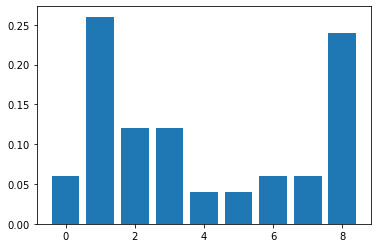

In [47]:
importance = abclf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Undersampled Dataset

In [48]:
abclf = AdaBoostClassifier(n_estimators = 50, random_state=seed).fit(X_train_us, y_train_us)

y_pred = abclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.997300  0.980531  0.988844      1130
         Yes   0.857143  0.977778  0.913495       135

    accuracy                       0.980237      1265
   macro avg   0.927221  0.979154  0.951170      1265
weighted avg   0.982342  0.980237  0.980803      1265



### Oversampled Dataset

In [49]:
abclf = AdaBoostClassifier(n_estimators = 50, random_state=seed).fit(X_train_os, y_train_os)

y_pred = abclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.999111  0.994690  0.996896      1130
         Yes   0.957143  0.992593  0.974545       135

    accuracy                       0.994466      1265
   macro avg   0.978127  0.993641  0.985721      1265
weighted avg   0.994632  0.994466  0.994511      1265



### Hybrid sampled Dataset

In [50]:
abclf = AdaBoostClassifier(n_estimators = 50, random_state=seed).fit(X_train_h, y_train_h)

y_pred = abclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.508850  0.674487      1130
         Yes   0.195652  1.000000  0.327273       135

    accuracy                       0.561265      1265
   macro avg   0.597826  0.754425  0.500880      1265
weighted avg   0.914161  0.561265  0.637432      1265



## XGBoost Classifier

### Imbalanced Dataset

In [51]:
from xgboost import XGBClassifier

# kfold = KFold(n_splits = 10, random_state = seed)
# scaler = StandardScaler()

# X_scaled = scaler.fit_transform(X)

# kfold = model_selection.KFold(n_splits = 10, random_state = 42)

# xgbclf = XGBClassifier(n_estimators = 50, random_state = seed)

# scoring = ['accuracy', 'precision', 'recall', 'f1']

# results = model_selection.cross_validate(xgbclf, X_scaled, y, cv = kfold, scoring = scoring)

# for name in results.keys():
#      print('{} {:.6f}'.format(name, np.average(results[name])))

In [52]:
xgbclf = XGBClassifier(n_estimators = 50, random_state=seed).fit(X_train, y_train)

y_pred = xgbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

C:\Users\USER\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          No   0.997343  0.996460  0.996901      1130
         Yes   0.970588  0.977778  0.974170       135

    accuracy                       0.994466      1265
   macro avg   0.983966  0.987119  0.985536      1265
weighted avg   0.994488  0.994466  0.994475      1265



Feature: 0, Score: 0.00695
Feature: 1, Score: 0.00647
Feature: 2, Score: 0.80607
Feature: 3, Score: 0.01545
Feature: 4, Score: 0.00358
Feature: 5, Score: 0.00387
Feature: 6, Score: 0.00512
Feature: 7, Score: 0.08410
Feature: 8, Score: 0.06839


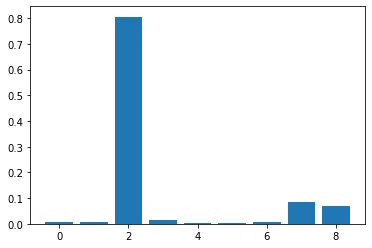

In [53]:
importance = xgbclf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Undersampled Dataset

In [54]:
xgbclf = XGBClassifier(n_estimators = 50, random_state=seed).fit(X_train_us, y_train_us)

y_pred = xgbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

[05:37:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          No   0.999100  0.982301  0.990629      1130
         Yes   0.870130  0.992593  0.927336       135

    accuracy                       0.983399      1265
   macro avg   0.934615  0.987447  0.958982      1265
weighted avg   0.985336  0.983399  0.983875      1265



C:\Users\USER\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### Oversampled Dataset

In [55]:
xgbclf = XGBClassifier(n_estimators = 50, random_state=seed).fit(X_train_os, y_train_os)

y_pred = xgbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

C:\Users\USER\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:37:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          No   0.997340  0.995575  0.996457      1130
         Yes   0.963504  0.977778  0.970588       135

    accuracy                       0.993676      1265
   macro avg   0.980422  0.986676  0.983523      1265
weighted avg   0.993729  0.993676  0.993696      1265



### Hybrid Sampled Dataset

In [56]:
xgbclf = XGBClassifier(n_estimators = 50, random_state=seed).fit(X_train_h, y_train_h)

y_pred = xgbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

[05:37:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

          No   1.000000  0.369027  0.539108      1130
         Yes   0.159198  1.000000  0.274669       135

    accuracy                       0.436364      1265
   macro avg   0.579599  0.684513  0.406889      1265
weighted avg   0.910270  0.436364  0.510887      1265



C:\Users\USER\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
